In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


# 1. PROJECT TOPIC INTRODUCTION

For our project, we thought to expand on our work in this area of stock prediction. We implemented Multi-Variate Linear Regression, Multi-Layer Perceptron Regression, and a Recurrent Neural Network in order to predict future stock price trends. We thought this would be a fun an interesting way to explore how Machine Learning can be used to model and predict a very real and important part of today's world. During this project, we experimented with using some new datasets we found for the stock market and created a host of new models using the techniques we learned during the course to see which ones do best at predicting things like long term stock prices, or daily stock prices.

# 2. DATA

We found out project data at https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices. This website provides professional-grade EOD stock prices, dividends, adjustments, and splits for publicly-traded US stocks. More importantly for our purposes, it is updated daily and has a history of the stock market back to 1996. This gave us ample data to explore past stock trends in order to predict future prices. Each data set we analyzed forom the multi-tabled data, as seen below, consisted of thirteen columns and roughly 10,000 columns. One of the initial issues we came across was the raw prices and scaling the prices causes all the values to consistently trend upwards. Thus we could not predict future prices based on the past raw and scaled prices. To fix this we altered our approach to predict the percent-changed instead. So ultimately we are aiming to predict the change in price, for example, five dollars up or five dollars down, rather than a change form ten dollars to fifteen dollars to vice versa.

In [4]:
pfeStock = pd.read_csv("EOD-PFE.csv").iloc[::-1,0:5]
koStock = pd.read_csv("EOD-KO.csv").iloc[::-1,0:5]
msftStock = pd.read_csv("EOD-MSFT.csv").iloc[::-1,0:5]
wmtStock = pd.read_csv("EOD-WMT.csv").iloc[::-1,0:5]
baStock = pd.read_csv("EOD-BA.csv").iloc[::-1,0:5]

# 3. DATA CLEANING

In order to conduct our analysis, we had to do some extreme data cleaning. While we did not have many irrelevant columns. We chose to omit everything except for closing price as it allowed for us to analyze a more clear relationship between data and prediction. With this change, we were still able to get a good prediction. However, we could not run our analysis on a single column of the closing price. So we took the CSV files and manipulated the single row into a full matrix of time predicted values. We did this by using a sliding window method. The method functions by using 5 days to predict the 6th. Then sliding that by 1 i.e. shift it up and see how those 5 days predict the 6th. With this method we could take a single column and turning it into whatever size matrix we needed by predicting every value in the column using the 5 value above it or below it.

<b>Sliding Data:</b> 
Here we turned time series into a form into one that would fit MLP and RNN of keras. In the table shown below column 5 shows the latest closing price and is used as the y-training label. 

In [5]:
def getSlidingData(data, column, windowSize):
    shape = data.shape
    formatted = []
    for i in range(0,shape[0]-windowSize):
        formatted.append(data.iloc[i:i+windowSize, column].tolist())
    formatted = pd.DataFrame(formatted)
    return formatted

In [6]:
formattedPfe = getSlidingData(pfeStock, 4, 6)
formattedMsft = getSlidingData(msftStock, 4, 6)
formattedBa = getSlidingData(baStock, 4, 6)
formattedPfe.head() 

,0,1,2,3,4,5
0,28.01,28.37,28.27,28.28,28.30,28.45
1,28.37,28.27,28.28,28.30,28.45,28.67
2,28.27,28.28,28.30,28.45,28.67,28.31
3,28.28,28.30,28.45,28.67,28.31,28.51
4,28.30,28.45,28.67,28.31,28.51,28.71


<b>Percent Changes:</b>
Here is a another way we represented the stock data. In the table above, the data is in a normalized form with a mean of 0 and variance around it.

In [7]:
def getPercentages(data, column):
    shape = data.shape
    newindex = range(0,shape[0]-2)
    price1 = np.array(data.iloc[0:shape[0]-2, column].tolist())
    price2 = np.array(data.iloc[1:shape[0]-1, column].tolist())

    percentage = price1 - price2 
    percentage *= (100/price2)
    percentage = pd.DataFrame([newindex, percentage.tolist()]).T
    
    return percentage.iloc[::-1]

In [8]:
percentPfe = getPercentages(pfeStock, 4)
percentMsft = getPercentages(msftStock, 4)
percentBa = getPercentages(baStock, 4)

In [9]:
formattedPPfe = getSlidingData(percentPfe, 1, 6)
formattedPMsft = getSlidingData(percentMsft, 1, 6)
formattedPBa = getSlidingData(percentBa, 1, 6)

formattedPPfe.head()

,0,1,2,3,4,5
0,-0.330306,-0.193317,0.276702,0.607064,1.316511,0.514348
1,-0.193317,0.276702,0.607064,1.316511,0.514348,0.188527
2,0.276702,0.607064,1.316511,0.514348,0.188527,-1.989247
3,0.607064,1.316511,0.514348,0.188527,-1.989247,0.493692
4,1.316511,0.514348,0.188527,-1.989247,0.493692,-0.163755


# 4. EXPLORATORY DATA ANALYSIS

First in this section we begin by creating two graphs for three of the stocks we are analyzing (PFE, MSFT, and BA).  The first plot simply shows how the stocks price changed over time starting from the date 9/3/13 and moving forward in time one day at a time.  We note that to create this plot we had to reverse the order that is given in the CSV files since they had the oldest date at the bottom.  Then the second plot shows the percent change for each day as time progresses forward.  From these plots below we can see that the daily percent change is very erratic and can very greatly from one day to the next (just since it is a large positive percent change one day doesn't mean that it will be similar or even positive the next few days)

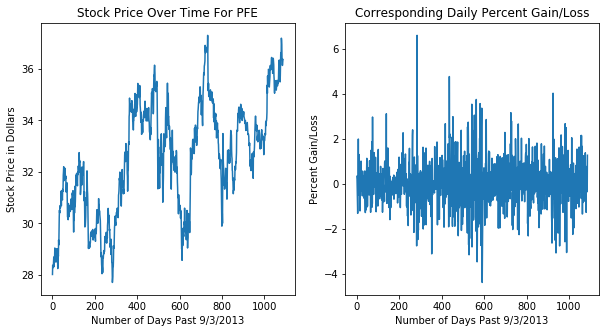

In [10]:
plt.figure(figsize=(10, 5))

mashY1 = pfeStock.iloc[0:1091,4].tolist()
plt.subplot(1,2,1)
plt.title("Stock Price Over Time For PFE")
plt.xlabel("Number of Days Past 9/3/2013")
plt.ylabel("Stock Price in Dollars")
plt.plot(range(0,1090),mashY1)

mashY2 = getPercentages(pfeStock, 4).iloc[:,1]
mashY2 = -1*mashY2                                #Multiplying by -1 to account for csv file being backwards
plt.subplot(1,2,2)
plt.title("Corresponding Daily Percent Gain/Loss")
plt.xlabel("Number of Days Past 9/3/2013")
plt.ylabel("Percent Gain/Loss")
plt.plot(range(0,1088),mashY2)

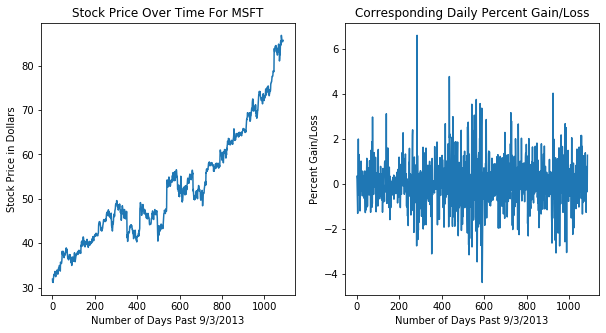

In [11]:
plt.figure(figsize=(10, 5))

mashY1 = msftStock.iloc[0:1091,4].tolist()
plt.subplot(1,2,1)
plt.title("Stock Price Over Time For MSFT")
plt.xlabel("Number of Days Past 9/3/2013")
plt.ylabel("Stock Price in Dollars")
plt.plot(range(0,1090),mashY1)

mashY3 = getPercentages(msftStock, 4).iloc[:,1]
mashY3 = -1*mashY3                              #Multiplying by -1 to account for csv file being backwards
plt.subplot(1,2,2)
plt.title("Corresponding Daily Percent Gain/Loss")
plt.xlabel("Number of Days Past 9/3/2013")
plt.ylabel("Percent Gain/Loss")
plt.plot(range(0,1088),mashY2)

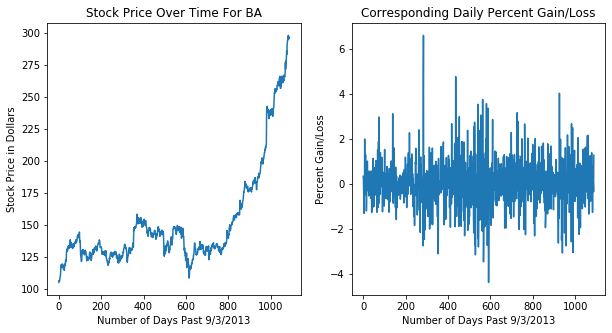

In [12]:
plt.figure(figsize=(10, 5))

mashY1 = baStock.iloc[0:1091,4].tolist()
plt.subplot(1,2,1)
plt.title("Stock Price Over Time For BA")
plt.xlabel("Number of Days Past 9/3/2013")
plt.ylabel("Stock Price in Dollars")
plt.plot(range(0,1090),mashY1)

mashY4 = getPercentages(baStock, 4).iloc[:,1]
mashY4 = -1*mashY4                               #Multiplying by -1 to account for csv file being backwards
plt.subplot(1,2,2)
plt.title("Corresponding Daily Percent Gain/Loss")
plt.xlabel("Number of Days Past 9/3/2013")
plt.ylabel("Percent Gain/Loss")
plt.plot(range(0,1088),mashY2)

Next in this section we try to make further sense of percent change data by making histograms for each of the three stocks.  Looking at the graphs below we can see that generally each of these graphs have approximately a normal distribution centered around zero.  What this means is that on most days these stocks have a percent gain/loss in price that is very close to zero. 

We also performed some statistical tests in order to determine the average percent gain/loss for each of the stocks along with the average variance and standard deviation for each stock.  After doing this we note that we found all of the average values to be above zero (this corresponds in the histograms being slightly skewed to the right of zero) which makes sense since each of these 3 stocks had a positive net gain over the total time period we were looking at.  Then another conclusion we can make about the stocks from this statistical analysis is that the larger the standard deviation from zero a stock had meant the more volatile that stocks price was day to day.

With this being said we could see that MSFT had the largest standard deviation from zero making it the most volatile stock that we are analyzing.  Then a final conclusion we can make from looking at the graphs is that the outliers on these histograms translated to days where the stock had massive gains/losses in price.

Average Gain/Loss Percentage Per Day For PFE was:  0.018313266700302366
Variance for PFE was:  1.1146295468222953
Standard Deviation for PFE was:  1.0557601748608891


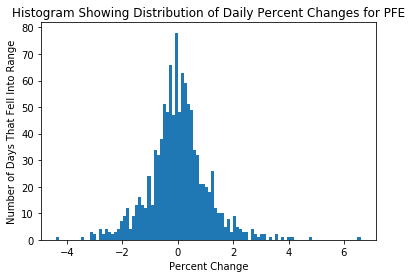

In [13]:
averageVal = sum(mashY2)/len(mashY2)
variance = sum([((currVal-0)**2) for currVal in mashY2]) / len(mashY2)
#Important to note that we replace subtracting off 
#off the average value in this formulato subtracting 
#zero in order to calculate how volatile the stock is 
#instead of how much it changes from its average increase/loss

standardDev = variance** 0.5
print("Average Gain/Loss Percentage Per Day For PFE was: ", averageVal)
print("Variance for PFE was: ", variance)
print("Standard Deviation for PFE was: ", standardDev)
plt.hist(mashY2, bins = 100)
plt.xlabel("Percent Change")
plt.ylabel("Number of Days That Fell Into Range")
plt.title("Histogram Showing Distribution of Daily Percent Changes for PFE")
plt.show()

Average Gain/Loss Percentage Per Day For MSFT was:  0.08159492609609022
Variance for MSFT was:  1.8550106860028879
Standard Deviation for MSFT was:  1.3619877701370477
0.08159492609609022


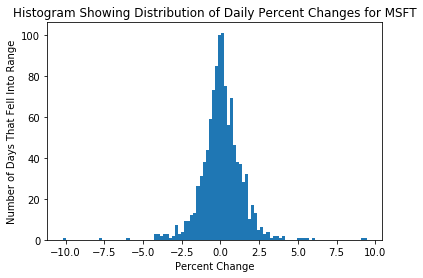

In [14]:
averageVal = sum(mashY3)/len(mashY3)
variance = sum([((currVal-0)**2) for currVal in mashY3]) / len(mashY3)  #Important to note that we replace subtracting off 
                                                                        #off the average value in this formulato subtracting 
                                                                        #zero in order to calculate how volatile the stock is 
                                                                #instead of how much it changes from its average increase/loss

standardDev = variance** 0.5
print("Average Gain/Loss Percentage Per Day For MSFT was: ", averageVal)
print("Variance for MSFT was: ", variance)
print("Standard Deviation for MSFT was: ", standardDev)
print(averageVal)
plt.hist(mashY3, bins = 100)
plt.xlabel("Percent Change")
plt.ylabel("Number of Days That Fell Into Range")
plt.title("Histogram Showing Distribution of Daily Percent Changes for MSFT")
plt.show()

Average Gain/Loss Percentage Per Day For BA was:  0.08634555789320689
Variance for BA was:  1.7591896851092115
Standard Deviation for BA was:  1.3263444820668617
0.08634555789320689


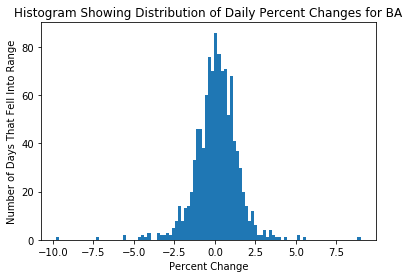

In [15]:
averageVal = sum(mashY4)/len(mashY4)
variance = sum([((currVal-0)**2) for currVal in mashY4]) / len(mashY4)
standardDev = variance** 0.5
print("Average Gain/Loss Percentage Per Day For BA was: ", averageVal)
print("Variance for BA was: ", variance)
print("Standard Deviation for BA was: ", standardDev)
print(averageVal)
plt.hist(mashY4, bins = 100)
plt.xlabel("Percent Change")
plt.ylabel("Number of Days That Fell Into Range")
plt.title("Histogram Showing Distribution of Daily Percent Changes for BA")
plt.show()

# 5. MODELS AND 6. ANALYSIS SECTIONS COMBINED

# MULTI-VARIATE LINEAR REGRESSION

Our main idea for using the Multi-Variate Linear Regression was to give each of the days in the N-window a weight. We can then look at these weights to see which day is most impactful. We used this as a benchmark comparing the mean squared error to that of our Multi-Layer Perceptron Regression and Recurrent Neural Network.

In [16]:
# Multivariate-Linear Regression using closing prices
regLin = LinearRegression().fit(formattedPfe.iloc[0:1000,0:5], formattedPfe.iloc[0:1000,5])
score = mean_squared_error(regLin.predict(formattedPfe.iloc[1000:1083,0:5]).tolist(), formattedPfe.iloc[1000:1083,5])
print("MSE: ", score, "\n")

MSE:  0.0827007937035259 



Text(0.5, 0, 'Relative Dates')

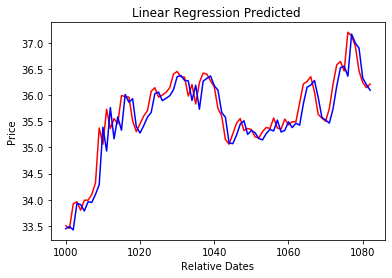

In [17]:
# Predicted Prices
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(range(1000,1083), formattedPfe.iloc[1000:1083,5].tolist(), color='r')
ax1.plot(range(1000,1083), regLin.predict(formattedPfe.iloc[1000:1083,0:5]).tolist(), color='b')
ax1.set_title('Linear Regression Predicted ')
ax1.set_ylabel('Price')
ax1.set_xlabel('Relative Dates')

In [18]:
# Multivariate-Linear Regression using closing percent changes
regLin = LinearRegression().fit(formattedPPfe.iloc[0:1000,0:5], formattedPPfe.iloc[0:1000,5])
score = mean_squared_error(regLin.predict(formattedPPfe.iloc[1000:1083,0:5]).tolist(), formattedPPfe.iloc[1000:1083,5])
print("MSE: ", score, "\n")

MSE:  0.8197650587155996 



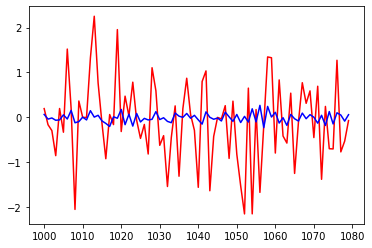

In [19]:
# Predicted Prices
mashY = formattedPPfe.iloc[0:1000,5].tolist() + regLin.predict(formattedPPfe.iloc[1000:1083,0:5]).tolist()
plt.plot(range(1000,1080), formattedPPfe.iloc[1000:1080,5].tolist(), color='r')
plt.plot(range(1000,1080), regLin.predict(formattedPPfe.iloc[1000:1080,0:5]).tolist(), color='b')

# Multi-Layer Perceptron Regression

Here we used linear and exponential activation because it works with our regression problem. Similarly, we used exponential to exaggerate large changes. We also used tanh to predict percentages to experiment with a nonlinear distribution. Our ultimate hope was that each neuron can learn significant N-window trends.

Note: We scaled stock prices to between 0 and 1 to normalize https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029

In [20]:
# Linear activation of prices
input_shape = (5,)

mlp = Sequential()
mlp.add(Dense(50, input_shape=input_shape, activation='linear'))
mlp.add(Dense(25, activation='linear'))
mlp.add(Dense(10, activation='linear'))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

sc = MinMaxScaler(feature_range=(0,1))
set_scaled = sc.fit_transform(formattedPfe)
set_scaled = pd.DataFrame(set_scaled)

mlp.fit(set_scaled.iloc[0:1000,0:5], set_scaled.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(set_scaled.iloc[1000:1083,0:5], set_scaled.iloc[1000:1083,5])
print('MSE: ', eval[1], 'MAE: ', eval[2])

83/83 [==============================] - 0s 36us/step
MSE:  0.0022819682490080595 MAE:  0.04027724266052246


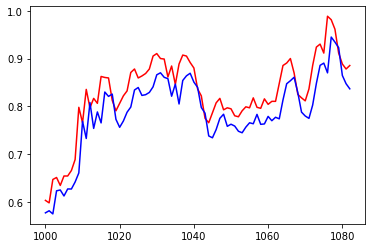

In [21]:
real = set_scaled.iloc[1000:1083,5].tolist()
predict = mlp.predict(set_scaled.iloc[1000:1083,0:5])
plt.plot(range(1000,1083), real, color='r')
plt.plot(range(1000,1083), predict, color='b')

In [22]:
# Changed activation to MAE
input_shape = (5,)

mlp = Sequential()
mlp.add(Dense(50, input_shape=input_shape, activation='linear'))
mlp.add(Dense(25, activation='linear'))
mlp.add(Dense(10, activation='linear'))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

sc = MinMaxScaler(feature_range=(0,1))
set_scaled = sc.fit_transform(formattedPfe)
set_scaled = pd.DataFrame(set_scaled)

mlp.fit(set_scaled.iloc[0:1000,0:5], set_scaled.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(set_scaled.iloc[1000:1083,0:5], set_scaled.iloc[1000:1083,5])
print('MSE: ', eval[1], 'MAE: ', eval[2])

83/83 [==============================] - 0s 36us/step
MSE:  0.003567634616047144 MAE:  0.053248487412929535


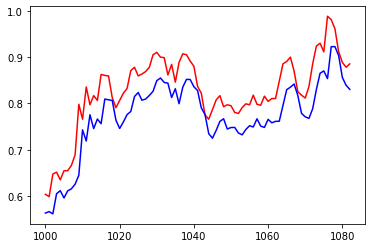

In [23]:
real = set_scaled.iloc[1000:1083,5].tolist()
predict = mlp.predict(set_scaled.iloc[1000:1083,0:5])
plt.plot(range(1000,1083), real, color='r')
plt.plot(range(1000,1083), predict, color='b')

In [24]:
# Exponential activation
input_shape = (5,)

mlp = Sequential()
mlp.add(Dense(50, input_shape=input_shape, activation='exponential'))
mlp.add(Dense(25, activation='exponential'))
mlp.add(Dense(10, activation='exponential'))
mlp.add(Dense(1, activation='exponential'))
mlp.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

sc = MinMaxScaler(feature_range=(0,1))
set_scaled = sc.fit_transform(formattedPfe)
set_scaled = pd.DataFrame(set_scaled)

mlp.fit(set_scaled.iloc[0:1000,0:5], set_scaled.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(set_scaled.iloc[1000:1083,0:5], set_scaled.iloc[1000:1083,5])
print('MSE: ', eval[1], 'MAE: ', eval[2],)

83/83 [==============================] - 0s 48us/step
MSE:  nan MAE:  nan


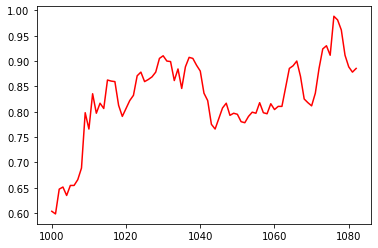

In [25]:
real = set_scaled.iloc[1000:1083,5].tolist()
predict = mlp.predict(set_scaled.iloc[1000:1083,0:5])
plt.plot(range(1000,1083), real, color='r')
plt.plot(range(1000,1083), predict, color='b')

In [26]:
# linear activation on percent changes
input_shape = (5,)

mlp = Sequential()
mlp.add(Dense(50, input_shape=input_shape, activation='linear'))
mlp.add(Dense(25,  activation='linear'))
mlp.add(Dense(10, activation='linear'))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

mlp.fit(formattedPPfe.iloc[0:1000,0:5], formattedPPfe.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(formattedPPfe.iloc[1000:1083,0:5], formattedPPfe.iloc[1000:1083,5])
print('MSE: ', eval[1], 'mean_absolute_error: ', eval[2])

82/82 [==============================] - 0s 24us/step
MSE:  0.8380967974662781 mean_absolute_error:  0.7152563333511353


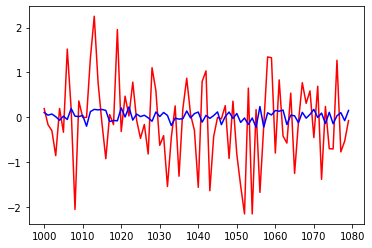

In [27]:
real = formattedPPfe.iloc[1000:1080,5].tolist()
predict = mlp.predict(formattedPPfe.iloc[1000:1080,0:5])
plt.plot(range(1000,1080), real, color='r')
plt.plot(range(1000,1080), predict, color='b')

In [28]:
# tanh activation on percent changes
input_shape = (5,)

mlp = Sequential()
mlp.add(Dense(50, input_shape=input_shape, activation='tanh'))
mlp.add(Dense(25,  activation='tanh'))
mlp.add(Dense(10, activation='tanh'))
mlp.add(Dense(1, activation='tanh'))
mlp.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

mlp.fit(formattedPPfe.iloc[0:1000,0:5], formattedPPfe.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(formattedPPfe.iloc[1000:1083,0:5], formattedPPfe.iloc[1000:1083,5])
print('MSE: ', eval[1], 'mean_absolute_error: ', eval[2])

82/82 [==============================] - 0s 36us/step
MSE:  0.8320959806442261 mean_absolute_error:  0.7319838404655457


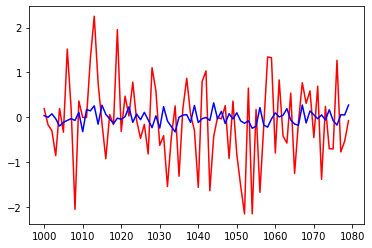

In [29]:
real = formattedPPfe.iloc[1000:1080,5].tolist()
predict = mlp.predict(formattedPPfe.iloc[1000:1080,0:5])
plt.plot(range(1000,1080), real, color='r')
plt.plot(range(1000,1080), predict, color='b')

Analysis:
- Losses MSE and MAE are fairly similair and each activation results in insignificant differences
- Linear and exponential activation do not yeild much differences for either prices and 

Finally below we conduct hyperparameter tuning on the best MLP model that we have found thus far which was the MLP with linear activation functions.  In this hyperparameter tuning process we will be attempting to find the best number of epochs to trian our model for that balances giving the model enough epochs to learn, but not enough to overfit to the training data. What you will see in the graph below is the resulting mean squared error that the same model produces when trained using different numbers of epochs.  Now the results of this hyperparameter tuning tend to really vary a lot between runs however a few main characteristics almost always stay the same.  What you will most likely see is that the MSE starts off at a high value when the model is trained using only 1-3 epochs.  Then usually what happens is the MSE goes down from these values and you can generally find the minimum MSE somewhere between 5-10 epochs.  One interesting thing that we didn't understand was why the MSE tends to be so volatile jumping up and down in performance in this range.  Then one final thing that you will notice is generally the MSE tends to start to go back up as we approach the much higher numbers of epochs which we suspect is due to overfitting.

83/83 [==============================] - 0s 24us/step
MSE:  0.003995341714471579 MAE:  0.055270854383707047
83/83 [==============================] - 0s 36us/step
MSE:  0.0010900484630838037 MAE:  0.026480797678232193
83/83 [==============================] - 0s 36us/step
MSE:  0.0011108724866062403 MAE:  0.025274738669395447
83/83 [==============================] - 0s 36us/step
MSE:  0.002091641305014491 MAE:  0.03792842477560043
83/83 [==============================] - 0s 48us/step
MSE:  0.0008855449268594384 MAE:  0.02257976494729519
83/83 [==============================] - 0s 36us/step
MSE:  0.0008828764548525214 MAE:  0.022516487166285515
83/83 [==============================] - 0s 24us/step
MSE:  0.000930600508581847 MAE:  0.022759145125746727
83/83 [==============================] - 0s 24us/step
MSE:  0.0009116399451158941 MAE:  0.0223322045058012
83/83 [==============================] - 0s 36us/step
MSE:  0.0011515476508066058 MAE:  0.025833049789071083
83/83 [===================

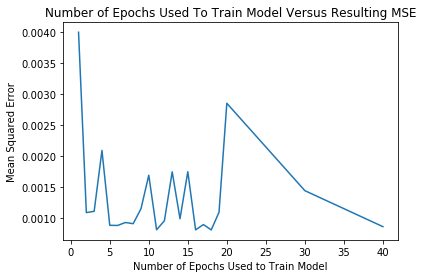

In [30]:
#first creating an array of all the different epoch training numbers we want to try
numEpochs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]

currLoss = []

for currNum in numEpochs:
    # Linear activation of prices
    input_shape = (5,)

    mlp = Sequential()
    mlp.add(Dense(50, input_shape=input_shape, activation='linear'))
    mlp.add(Dense(25, activation='linear'))
    mlp.add(Dense(10, activation='linear'))
    mlp.add(Dense(1, activation='linear'))
    mlp.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

    sc = MinMaxScaler(feature_range=(0,1))
    set_scaled = sc.fit_transform(formattedPfe)
    set_scaled = pd.DataFrame(set_scaled)

    mlp.fit(set_scaled.iloc[0:1000,0:5], set_scaled.iloc[0:1000,5], epochs=currNum, batch_size=10, verbose=0, validation_split=0.15)
    eval = mlp.evaluate(set_scaled.iloc[1000:1083,0:5], set_scaled.iloc[1000:1083,5])
    print('MSE: ', eval[1], 'MAE: ', eval[2])
    newLossVal = eval[1]
    currLoss.append(newLossVal)

plt.plot(numEpochs, currLoss)
plt.title("Number of Epochs Used To Train Model Versus Resulting MSE")
plt.ylabel("Mean Squared Error")
plt.xlabel("Number of Epochs Used to Train Model")
plt.show()
    


# Recurrent Neural Network

RNN: We made this model for time series data

Note: scaled stock prices to between 0 and 1 to normalize https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029

In [31]:
rnn = Sequential()
rnn.add(LSTM(units=25,return_sequences=True,input_shape = (5,1)))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25))
rnn.add(Dense(units = 1))
rnn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

sc = MinMaxScaler(feature_range=(0,1))
set_scaled = sc.fit_transform(formattedPfe)
set_scaled = pd.DataFrame(set_scaled)

xInput = np.array(formattedPfe.iloc[0:1083,0:5])
xInput = np.reshape(xInput, (xInput.shape[0], xInput.shape[1], 1))
rnn.fit(xInput[0:1000], set_scaled.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0)
eval = rnn.evaluate(xInput[1000:1083], set_scaled.iloc[1000:1083,5])
print('MSE: ', eval[1], 'mean_absolute_error: ', eval[2])

83/83 [==============================] - 0s 3ms/step
MSE:  0.0016034949803724885 mean_absolute_error:  0.03276374936103821


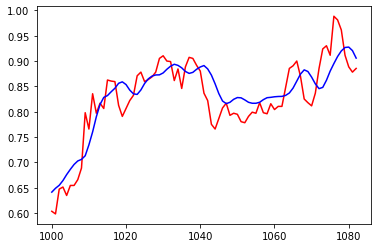

In [32]:
real = set_scaled.iloc[1000:1083,5].tolist()
predict = rnn.predict(xInput[1000:1083])
plt.plot(range(1000,1083), real, color='r')
plt.plot(range(1000,1083), predict, color='b')

In [33]:
rnn = Sequential()
rnn.add(LSTM(units=25,return_sequences=True,input_shape = (5,1)))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25))
rnn.add(Dense(units = 1))
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

sc = MinMaxScaler(feature_range=(0,1))
set_scaled = sc.fit_transform(formattedPfe)
set_scaled = pd.DataFrame(set_scaled)

xInput = np.array(formattedPfe.iloc[0:1083,0:5])
xInput = np.reshape(xInput, (xInput.shape[0], xInput.shape[1], 1))
rnn.fit(xInput[0:1000], set_scaled.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0)
eval = rnn.evaluate(xInput[1000:1083], set_scaled.iloc[1000:1083,5])
print('MSE: ', eval[1], 'mean_absolute_error: ', eval[2])

83/83 [==============================] - 0s 3ms/step
MSE:  0.011720390990376472 mean_absolute_error:  0.0995386615395546


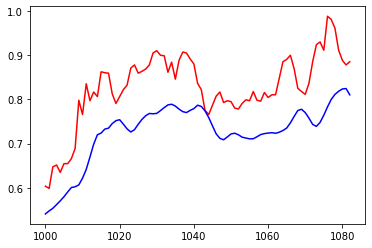

In [34]:
real = set_scaled.iloc[1000:1083,5].tolist()
predict = rnn.predict(xInput[1000:1083])
plt.plot(range(1000,1083), real, color='r')
plt.plot(range(1000,1083), predict, color='b')

In [35]:
rnn = Sequential()
rnn.add(LSTM(units=75,return_sequences=True,input_shape = (5,1)))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=50,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=5))
rnn.add(Dense(1, activation='linear'))
rnn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

xInput = np.array(formattedPPfe.iloc[0:1083,0:5])
xInput = np.reshape(xInput, (xInput.shape[0], xInput.shape[1], 1))
rnn.fit(xInput[0:1000], formattedPPfe.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0)
eval = rnn.evaluate(xInput[1000:1083], formattedPPfe.iloc[1000:1083,5])
print('MSE: ', eval[1], 'mean_absolute_error: ', eval[2])

82/82 [==============================] - 0s 3ms/step
MSE:  0.8210543990135193 mean_absolute_error:  0.6959407925605774


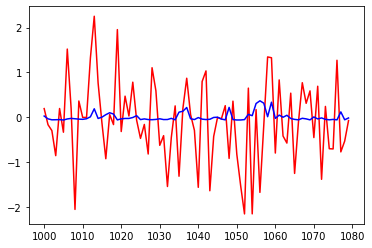

In [36]:
real = formattedPPfe.iloc[1000:1080,5].tolist()
predict = rnn.predict(xInput[1000:1080])
plt.plot(range(1000,1080), real, color='r')
plt.plot(range(1000,1080), predict, color='b')

In [37]:
rnn = Sequential()
rnn.add(LSTM(units=75,return_sequences=True,input_shape = (5,1)))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=50,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=5))
rnn.add(Dense(1, activation='linear'))
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error','mean_absolute_error'])

xInput = np.array(formattedPPfe.iloc[0:1083,0:5])
xInput = np.reshape(xInput, (xInput.shape[0], xInput.shape[1], 1))
rnn.fit(xInput[0:1000], formattedPPfe.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0)
eval = rnn.evaluate(xInput[1000:1083], formattedPPfe.iloc[1000:1083,5])
print('MSE: ', eval[1], 'mean_absolute_error: ', eval[2])

82/82 [==============================] - 0s 3ms/step
MSE:  0.8240612149238586 mean_absolute_error:  0.695416271686554


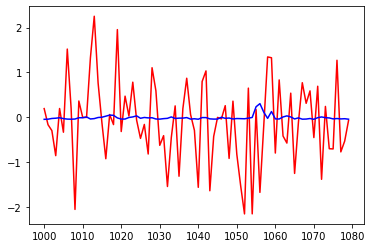

In [38]:
real = formattedPPfe.iloc[1000:1080,5].tolist()
predict = rnn.predict(xInput[1000:1080])
plt.plot(range(1000,1080), real, color='r')
plt.plot(range(1000,1080), predict, color='b')

# 7. DISCUSSION AND CONCLUSION

Ultimatley, we sought to predict the future percent change of stock prices by analysizing historical closing prices. We found that our prediction are usually shifted right of the historical data. This may be due to the fact that we attempted to predict the change in a stocks value soley based on its historical price. We now believe that to create a more accurate prediction we would need to incorperate more of the numerous other factors that affect stock price such as the sentiment of stock news, company balance sheets, the state of the general market, and prices of other stocks. We also found that predicting percent change in stock price was not feasible with our Recurrent Nueral Network. The changes in value are too erratic and seem to suggest past prices of the single stock do not affect the future price for NN. Although we may have been able to achieve a more accurate prediction by only focusing on a single model, it was a lot of fun trying multiple techniques and spending time figuring out how to apply the various things we learned in class to model and predict part of the real world. 